In [1]:
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
np.random.seed(2018)
X_MEAN = 20
X_STD_ERROR = 3
BETA_0 = 2
BETA_1 = -2.5

ERROR_FACTORY = {
    'normal': lambda size: stats.norm.rvs(0, 2, size=size),
    'uniform': lambda size: stats.uniform.rvs(-2, 4, size=size),
    'skew normal': lambda size: stats.skewnorm.rvs(
        5, -5/np.sqrt(1 + 5**2)*np.sqrt(2/np.pi), 1, size=size),
    't': lambda size: stats.t.rvs(3/2, 0, 1, size=size),
    'rademacher': lambda size: 2*stats.bernoulli.rvs(0.5, size=size) - 1,
}

In [3]:
experiments = pd.DataFrame(index=pd.MultiIndex.from_product([
    pd.Series([15, 30], dtype=np.int32),
    pd.Series(['normal','uniform', 'skew normal', 't'], dtype=np.object),
], names=['n', 'error_type'])).reset_index()
experiments

,n,error_type
0,15,normal
1,15,uniform
2,15,skew normal
3,15,t
4,30,normal
5,30,uniform
6,30,skew normal
7,30,t


In [4]:
from collections import OrderedDict

from stat570.linear_model.linear_regression import LinearRegression

def simulate(n, error_factory, num_trials, confidence_level=0.95, seed=2018):
    np.random.seed(seed)    
    X = stats.norm.rvs(X_MEAN, X_STD_ERROR, size=(n, 1))
    
    def simulate_trial():
        errors = error_factory(n)
        y = BETA_0 + np.squeeze(X*BETA_1) + errors
        linear_model = LinearRegression().fit(X, y)
        
        coefficients = linear_model.coefficients_
        
        return OrderedDict([
            ('beta_0_estimate', coefficients['estimate'][0]),
            ('beta_0_variance', np.square(coefficients['std_error'][0])),
            ('beta_1_estimate', coefficients['estimate'][1]),
            ('beta_1_variance', np.square(coefficients['std_error'][1])),
        ])
    return pd.DataFrame([simulate_trial() for _ in range(num_trials)])    

In [5]:
trial_results = []
for _, experiment in experiments.iterrows():
    trial_results.append(simulate(experiment['n'], ERROR_FACTORY[experiment['error_type']], 2048))

In [6]:
def summarize_result(experiment, result,
                     true_value,
                     estimate_key, variance_key, label):
    estimate = result[estimate_key]
    variance = result[variance_key]
        
    coverage = np.sum(np.abs(estimate - true_value) <=
           stats.t.isf((1 - 0.95)/2,
                       df=experiment['n']-2)*np.sqrt(variance))
    
    return OrderedDict([
        ('$n$', experiment['n']),
        ('Error Distribution', experiment['error_type']),
        ('{} Estimate'.format(label), estimate.mean()),        
        ('Sample Variance', estimate.var(ddof=1)),
        ('Least-squares Variance', variance.mean()),
        ('95% CI Coverage', coverage/len(result)),
        ('Shapiro-Wilk $p$-value', stats.shapiro(estimate)[1]),
    ])

beta_0_summaries = []
beta_1_summaries = []
for (idx, experiment), trial_result in zip(experiments.iterrows(), trial_results):
    beta_0_summaries.append(
        summarize_result(experiment, trial_result,
                         BETA_0,
                         'beta_0_estimate', 'beta_0_variance', '$\\hat{\\beta}_0$'))
    beta_1_summaries.append(
        summarize_result(experiment, trial_result,
                         BETA_1,
                         'beta_1_estimate', 'beta_1_variance', '$\\hat{\\beta}_1$'))
    
beta_0_summaries = pd.DataFrame(beta_0_summaries)
beta_1_summaries = pd.DataFrame(beta_1_summaries)

In [7]:
from IPython.core.display import HTML

with open('p1_beta_0_summary.tex', 'w') as f:
    f.write(beta_0_summaries.to_latex(escape=False, index=False).replace('%', '\\%'))
    
HTML(beta_0_summaries.to_html(index=False))

$n$,Error Distribution,$\hat{\beta}_0$ Estimate,Sample Variance,Least-squares Variance,95% CI Coverage,Shapiro-Wilk $p$-value
15,normal,1.981029,16.066709,16.462905,0.954102,0.440320
15,uniform,2.108807,5.488093,5.457236,0.948730,0.052002
15,skew normal,2.013222,1.706046,1.624730,0.943359,0.558366
15,t,2.223518,268.857783,447.847807,0.950195,0.000000
30,normal,2.023642,6.058565,6.067812,0.949707,0.635323
30,uniform,1.980790,2.039209,2.001988,0.941895,0.307742
30,skew normal,2.021499,0.566532,0.591055,0.954590,0.099939
30,t,1.468913,981.048353,559.866048,0.950684,0.000000


In [8]:
with open('p1_beta_1_summary.tex', 'w') as f:
    f.write(beta_1_summaries.to_latex(escape=False, index=False).replace('%', '\\%'))

HTML(beta_1_summaries.to_html(index=False))

$n$,Error Distribution,$\hat{\beta}_1$ Estimate,Sample Variance,Least-squares Variance,95% CI Coverage,Shapiro-Wilk $p$-value
15,normal,-2.499933,0.037590,0.038154,0.953613,0.447169
15,uniform,-2.505455,0.012717,0.012647,0.948242,0.045104
15,skew normal,-2.500507,0.003944,0.003765,0.944336,0.907067
15,t,-2.512479,0.543700,1.037909,0.948730,0.000000
30,normal,-2.502034,0.015370,0.015198,0.949219,0.744967
30,uniform,-2.499262,0.005189,0.005014,0.936523,0.101658
30,skew normal,-2.500797,0.001421,0.001480,0.956055,0.850093
30,t,-2.475815,2.229763,1.402287,0.950684,0.000000


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(
    figsize=(6, 8), nrows=len(experiments)//2, ncols=2)

for idx, trial_result in enumerate(trial_results):
    ax = axes[idx//2][idx % 2]
    experiment = experiments.loc[idx]
    sns.distplot(trial_result['beta_0_estimate'], fit=stats.norm,
                 kde=False, ax=ax, axlabel='')
    ax.set_title('$n = {}$, {} errors'.format(experiment['n'], experiment['error_type']))

fig.suptitle('$\\hat{\\beta}_0$ Estimates')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('p1_beta_hat_0_distribution.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


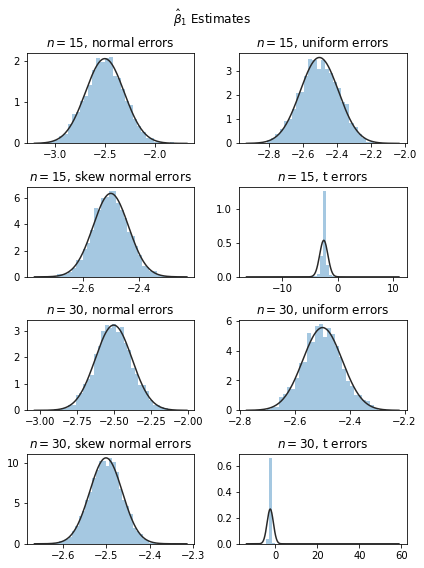

In [10]:
fig, axes = plt.subplots(
    figsize=(6, 8), nrows=len(experiments)//2, ncols=2)

for idx, trial_result in enumerate(trial_results):
    ax = axes[idx//2][idx % 2]
    experiment = experiments.loc[idx]
    sns.distplot(trial_result['beta_1_estimate'], fit=stats.norm,
                 kde=False, ax=ax, axlabel='')
    ax.set_title('$n = {}$, {} errors'.format(experiment['n'], experiment['error_type']))

fig.suptitle('$\\hat{\\beta}_1$ Estimates')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('p1_beta_hat_1_distribution.pdf', bbox_inches='tight')